In [1]:
#import casatasks as ctask
#import casatools as ctool
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from spectral_cube import SpectralCube as sc
import astropy.units as U
import warnings
warnings.filterwarnings('ignore')

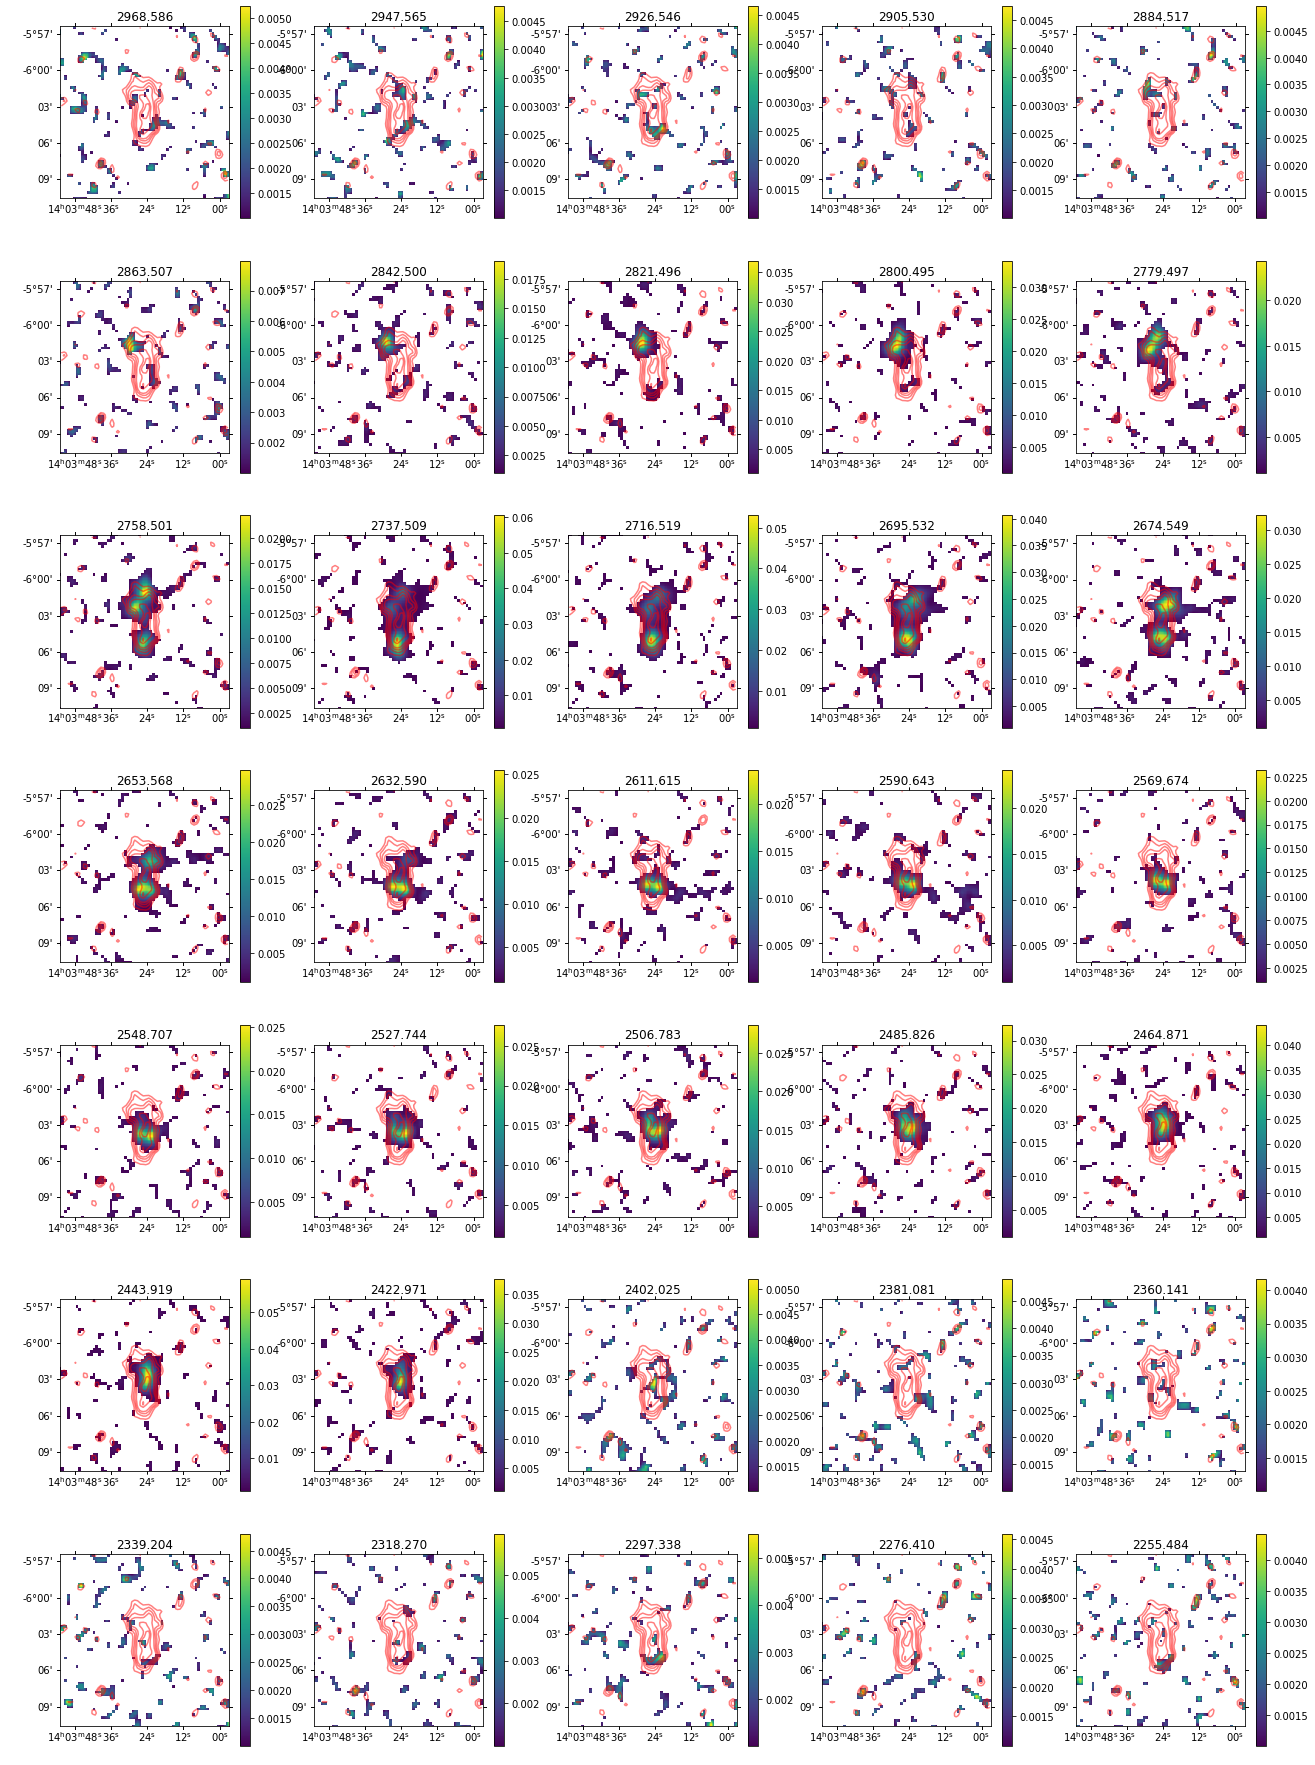

In [2]:
path="G1-data/VLA/"
cubeim=path+'J1403-box.image.fits'
newcube=sc.read(cubeim)
velcube=newcube.with_spectral_unit(unit=U.km/U.s, velocity_convention='optical',rest_value=1.420405761768*U.GHz) #Converting cube to vel scale
velcube_chan=velcube[15:50,:,:] #Channel Cuts
mask= (velcube_chan > 0.001 *U.Jy/U.beam) #Signal clip
vel_masked=velcube_chan.with_mask(mask)
mom0=vel_masked.moment(order=0) #mom0
mom0.write(path+'J1403-box.mom0.fits', overwrite=True)
vel_masked.write(path+'J1403velmasked.fits', overwrite=True)

levels =[1.15, 1.76, 2.37, 3.07, 4.8, 5.52]

plt.figure(figsize=(22,32))
for ii, i in enumerate(vel_masked.spectral_axis, start=1):
    #print(i,'',ii)
    ax = plt.subplot(7,5,ii, projection=vel_masked[0].wcs)
    im=ax.imshow(vel_masked[ii-1,:,:].value)   #Plot velcube_chan if the unmasked version is needed
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    plt.colorbar(im)
    ax.set_title('%.3f'%(vel_masked.spectral_axis[ii-1].value)) 
    ax.contour(mom0.data, colors=['red'], alpha=0.5, levels=levels)


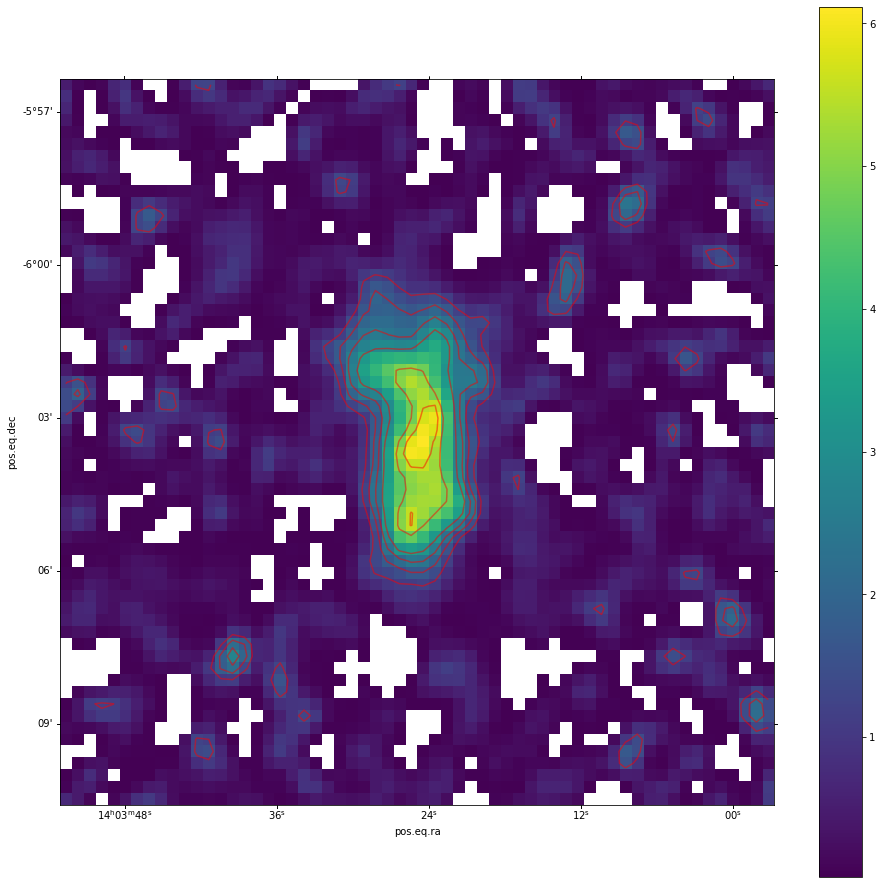

In [3]:
plt.figure(figsize=(16,16))
mo=plt.subplot(1,1,1,projection=vel_masked[0].wcs)
mom0plt=mo.imshow(mom0.data)
plt.colorbar(mom0plt,ax=mo)
mo.contour(mom0.data, colors=['red'], alpha=0.5, levels=levels)

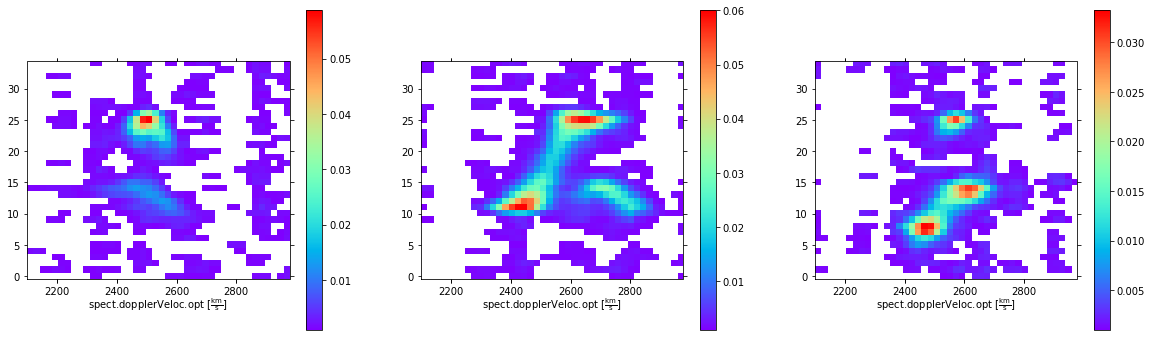

In [4]:
#PV Slice extractor and SpectralCube

from pvextractor import extract_pv_slice
from pvextractor.geometry import PathFromCenter
from astropy.coordinates import SkyCoord

#Optical PA

coords1 = SkyCoord('14h03m24.88s -06d04m09.14s')
paths1 = PathFromCenter(center=coords1, length=10 * U.arcmin, angle=171.7 * U.deg, width=1 * U.arcsec)
pvs1 = extract_pv_slice(vel_masked[:,:,:], paths1)

coords2 = SkyCoord('14h03m26.09s -06d01m51.20s')
paths2 = PathFromCenter(center=coords2, length=10 * U.arcmin, angle=85.7 * U.deg, width=1 * U.arcsec)
pvs2 = extract_pv_slice(vel_masked[:,:,:], paths2)

#By Eye general
coordg1 = SkyCoord('14h03m25.47s -06d02m55.44s')
pathg1 = PathFromCenter(center=coordg1, length=10 * U.arcmin, angle=273 * U.deg, width=1 * U.arcsec)
pvg1 = extract_pv_slice(vel_masked[:,:,:], pathg1)

#By eye S2
# coords2 = SkyCoord('14h03m26.09s -06d01m51.20s')
# paths2 = PathFromCenter(center=coords2, length=10 * U.arcmin, angle=351 * U.deg, width=1 * U.arcsec)
# pvs2 = extract_pv_slice(vel_masked[:,:,:], paths2)

#pv.writeto(path+'my_slice.fits',) 

plt.figure(figsize=(20,20))
ag1 = plt.subplot(3,3,1,projection=vel_masked.wcs, slices=(0,0,'x'))
pvg1im=ag1.imshow(pvg1.data, origin='lower', cmap='rainbow')
ag1.coords[2].set_format_unit(U.km / U.s)
ag1.coords[1].set_format_unit(U.arcmin)
ag1.coords[0].set_format_unit(U.arcmin)
ag1.invert_xaxis()
#ag1.yaxis.set_visible(False)
plt.colorbar(pvg1im)

as1 = plt.subplot(3,3,2,projection=vel_masked.wcs, slices=(0,0,'x'))
pvs1im=as1.imshow(pvs1.data,origin='lower', cmap='rainbow')
plt.colorbar(pvs1im)
as1.coords[2].set_format_unit(U.km / U.s)
as1.coords[1].set_format_unit(U.arcmin)
as1.coords[0].set_format_unit(U.arcmin)
as1.invert_xaxis()

as2 = plt.subplot(3,3,3,projection=vel_masked.wcs, slices=(0,0,'x'))
pvs2im=as2.imshow(pvs2.data, cmap='rainbow')
plt.colorbar(pvs2im)
as2.coords[2].set_format_unit(U.km / U.s)
as2.coords[1].set_format_unit(U.arcmin)
as2.coords[0].set_format_unit(U.arcmin)
as2.invert_xaxis()


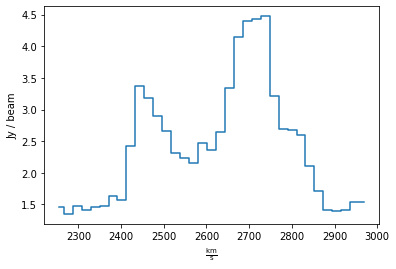

In [5]:
#Extract Spectrum

spec = vel_masked.sum(axis=(1,2))  
spec.quicklook()

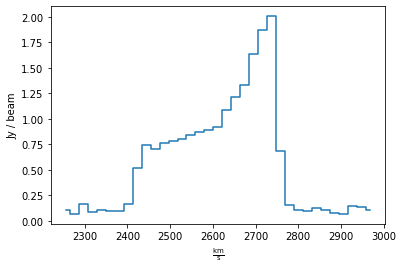

In [6]:
## Masked Spectrum Extraction -G1S1
import regions
#crtf_g1s1 = 'circle[[14:03:26.09, -06:01:01.75], 128"], coord=J2000'

ds9_g1s1 = 'J2000; circle(14:03:25.0288466330,-6:04:52.4365880048, 108")'  
cubeg1s1 = vel_masked.subcube_from_ds9region(ds9_g1s1)
#cubeg1s1[25,:,:].quicklook()
specg1s1 = cubeg1s1.sum(axis=(1, 2))
specg1s1.quicklook()

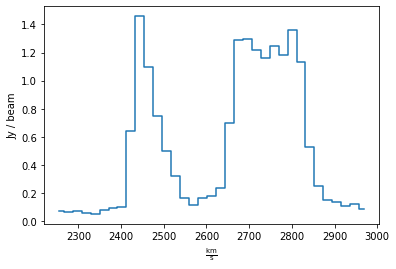

In [7]:
## Masked Spectrum Extraction -G1S2

ds9_g1s2 = 'J2000; circle(14:03:25.4202003499,-6:01:28.9965936862, 105")'  
cubeg1s2 = vel_masked.subcube_from_ds9region(ds9_g1s2)  
#cubeg1s2[25,:,:].quicklook()
specg1s2 = cubeg1s2.sum(axis=(1, 2))
specg1s2.quicklook()

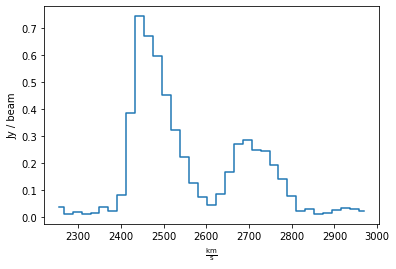

In [8]:
## Masked Spectrum Extraction -G1-bridge

bridgeg1 = regions.RectanglePixelRegion(regions.PixCoord(29.45, 31.96), width=21.76, height=2.43)  
cubeg1b = vel_masked.subcube_from_regions([bridgeg1])
#cubeg1b[25,:,:].quicklook()
specg1b = cubeg1b.sum(axis=(1, 2)) 
specg1b.quicklook()

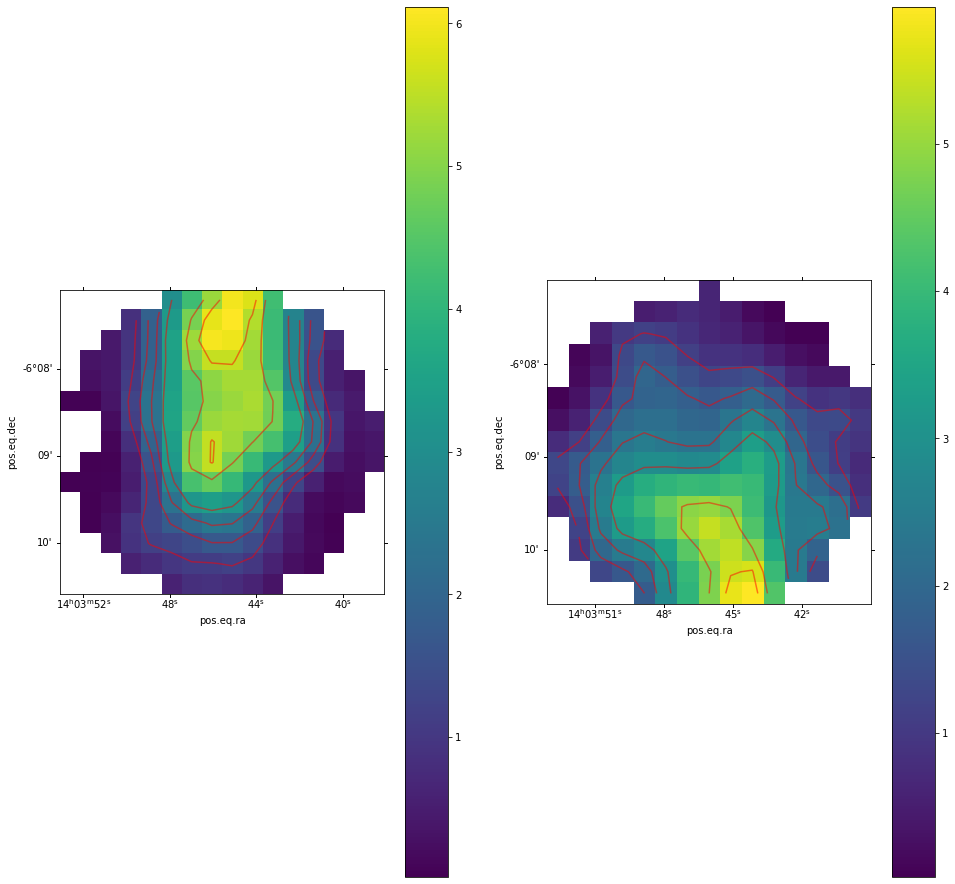

In [9]:
#Moment 0 for S1 and S2 using spectral cube 

mom0s1=cubeg1s1.moment(order=0) #mom0
mom0s1.write(path+'g1s1-mom0.fits', overwrite=True)
plt.figure(figsize=(16,16))
g1s1m0=plt.subplot(1,2,1,projection=vel_masked[0].wcs)
mom0s1plt=g1s1m0.imshow(mom0s1.value)
plt.colorbar(mom0s1plt,ax=g1s1m0)
g1s1m0.contour(mom0s1.data, colors=['red'], alpha=0.5, levels=levels)

mom0s2=cubeg1s2.moment(order=0) #mom0
mom0s2.write(path+'g1s2-mom0.fits', overwrite=True)
g1s2m0=plt.subplot(1,2,2,projection=vel_masked[0].wcs)
mom0s2plt=g1s2m0.imshow(mom0s2.value)
plt.colorbar(mom0s2plt,ax=g1s2m0)
g1s2m0.contour(mom0s2.data, colors=['red'], alpha=0.5, levels=levels)

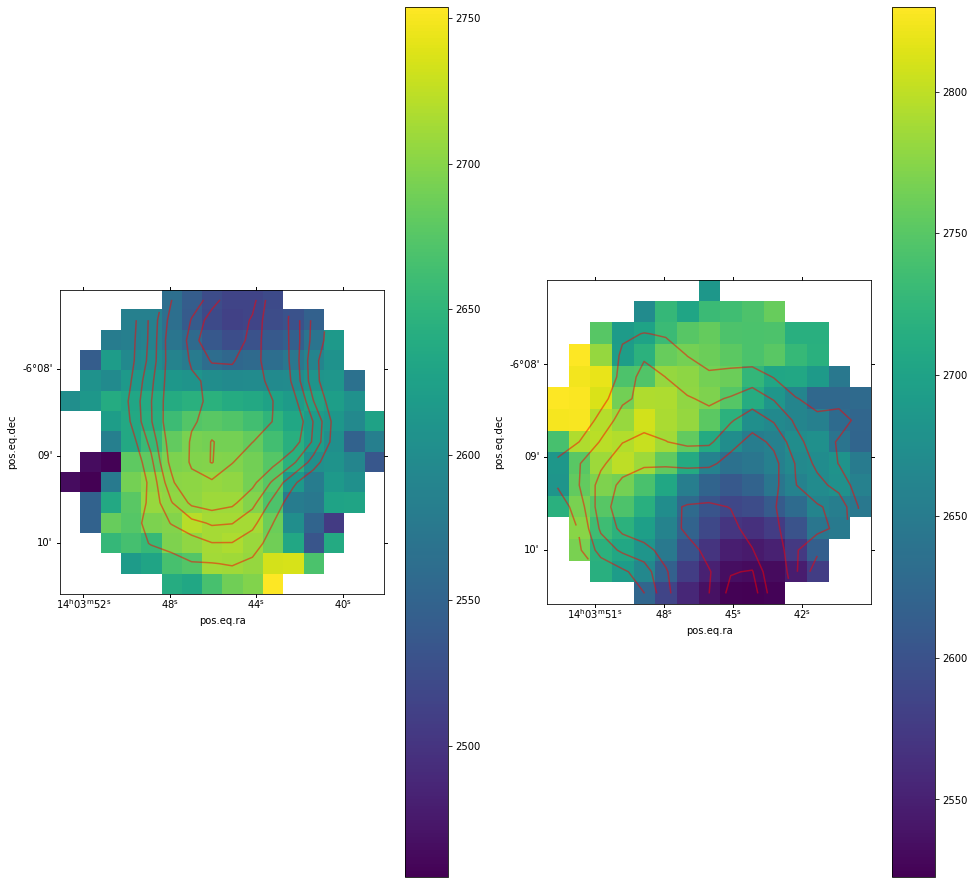

In [10]:
#Moment 1 for S1 and S2 using spectral cube 

mom1s1=cubeg1s1.moment(order=1) #mom1
#mom1s1.write(path+'g1s1-mom1.fits', overwrite=True)
plt.figure(figsize=(16,16))
g1s1m1=plt.subplot(1,2,1,projection=vel_masked[0].wcs)
mom1s1plt=g1s1m1.imshow(mom1s1.value)
plt.colorbar(mom1s1plt,ax=g1s1m1)
g1s1m1.contour(mom0s1.data, colors=['red'], alpha=0.5, levels=levels)

mom1s2=cubeg1s2.moment(order=1) #mom1
#mom1s2.write(path+'g1s2-mom1.fits', overwrite=True)
g1s2m1=plt.subplot(1,2,2,projection=vel_masked[0].wcs)
mom1s2plt=g1s2m1.imshow(mom1s2.value)
plt.colorbar(mom1s2plt,ax=g1s2m1)
g1s2m1.contour(mom0s2.data, colors=['red'], alpha=0.5, levels=levels)

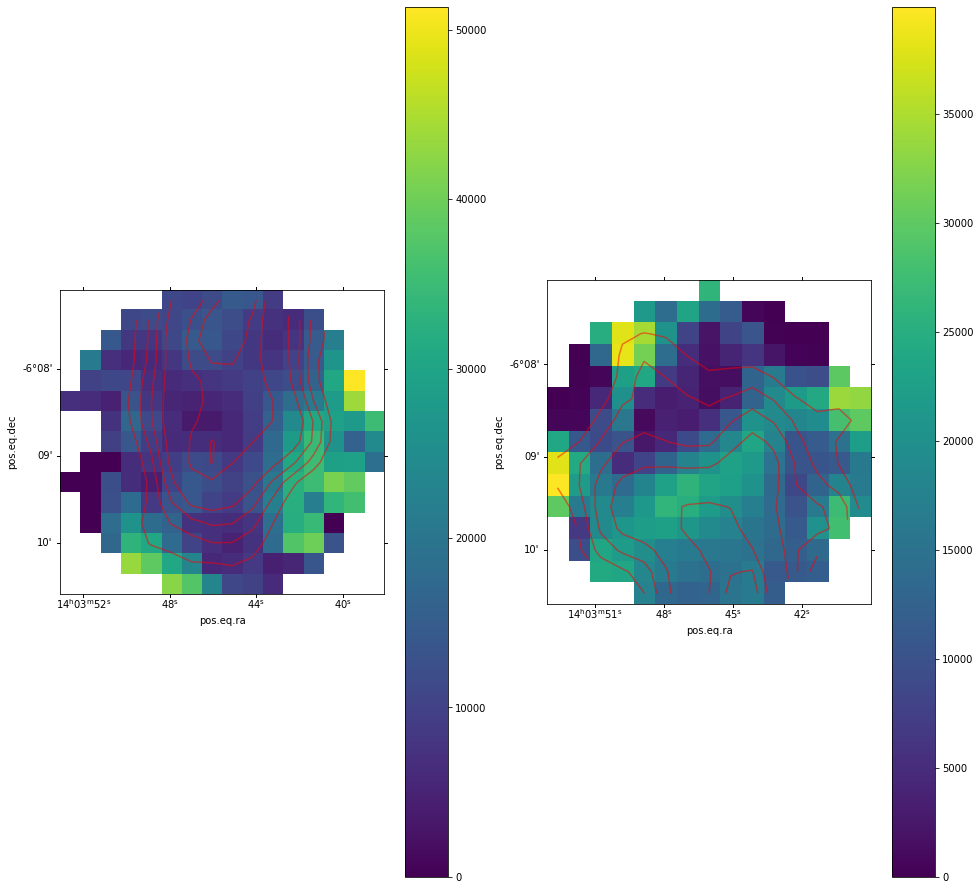

In [11]:
#Moment 2 for S1 and S2 using spectral cube 

mom2s1=cubeg1s1.moment(order=2) #mom2
#mom2s1.write(path+'g1s1-mom2.fits', overwrite=True)
plt.figure(figsize=(16,16))
g1s1m2=plt.subplot(1,2,1,projection=vel_masked[0].wcs)
mom2s1plt=g1s1m2.imshow(mom2s1.value)
plt.colorbar(mom2s1plt,ax=g1s1m2)
g1s1m2.contour(mom0s1.data, colors=['red'], alpha=0.5, levels=levels)

mom2s2=cubeg1s2.moment(order=2) #mom2
#mom2s2.write(path+'g1s2-mom2.fits', overwrite=True)
g1s2m2=plt.subplot(1,2,2,projection=vel_masked[0].wcs)
mom2s2plt=g1s2m2.imshow(mom2s2.value)
plt.colorbar(mom2s2plt,ax=g1s2m2)
g1s2m2.contour(mom0s2.data, colors=['red'], alpha=0.5, levels=levels)

## Calculations


In [12]:
### Beam Area in number of pixels
def beamArea(bmaj,bmin, cellx, celly):
    cellArea = cellx * celly
    bmaj = bmaj * 3600.0
    bmin = bmin * 3600.0
    fac  = np.pi / (4.0 * np.log(2.0))
    bArea = fac * bmaj * bmin
    return bArea / cellArea

### Obtain beam parameters from FITS file
def beam(fitsfile):
    f = fits.open(fitsfile)
    h = f[0].header
    bmaj = h['BMAJ']
    bmin = h['BMIN']
    cellx  = 3600. * np.abs(h['CDELT1'])
    celly  = 3600. * np.abs(h['CDELT2'])
    try:
        bpa  = h['BPA']
    except KeyError:
        bpa = np.nan
    return bmaj, bmin, bpa, cellx, celly

### Determine flux density
def fluxDens(fitsfile, flg):
    f = fits.open(fitsfile)
    data = f[0].data

    if len(data.shape) > 2:
        data = data[0]
    
    bpars = beam(fitsfile)
    area  = beamArea(bpars[0],bpars[1], bpars[3], bpars[4])
    print('Beam Area = %.2f' %area)
    
    if flg == 0:
        flux=np.nansum(data)
        return flux/area, np.nanstd(data)
        print('You used nansum')
    elif flg == 1:

        fluxes = []
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if not np.isnan(data[i,j]):
                    fluxes.append(data[i,j])

        flux  = np.sum(fluxes)
        print('You used For Loop')
        return flux/area, np.std(fluxes)

### Calculate HI mass
mom0map=path+'J1403-box.mom0.fits'
flag=0 # 0 for nansum 1 for for loop

lineflux, flerr = fluxDens(mom0map, flag)
galDist = 41

galMass = 2.36e5 * (galDist**2) * lineflux
logMass = np.log10(galMass)

print(lineflux, ' +/- ', flerr)
print('Log HI mass = ',logMass)

Beam Area = 13.34
132.0673923762334  +/-  0.89280164
Log HI mass =  10.719275319344698


### S1
Log HI mass = 10.09 Msun at 41.00 Mpc
Integrated Flux = 31.07
Beam Area = 13.34

### S2
Log HI mass = 10.06 Msun at 41.00 Mpc
Integrated Flux = 28.73
Beam Area = 13.34

### S1 + S2
Log HI mass = 10.72 Msun at 41.00 Mpc
Integrated Flux = 132.07
Beam Area = 13.34